In [1]:
import sys
import os
import json
import numpy as np
import glob
import importlib
%matplotlib inline
import matplotlib.pyplot as plt

import util_human_model_comparison
import util_psychophysics_figures
importlib.reload(util_psychophysics_figures)


### SPECIFY THE OUTERMOST DIRECTORY CONTAINING ALL MODELS
model_dir = '/om2/user/msaddler/pitchnet/saved_models/'

### SPECIFY RESULTS DICT BASENAME: determines which experiment to plot
# results_dict_basename = 'EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_MistunedHarm_v00_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_AltPhase_v01_bestckpt_results_dict.json'
results_dict_basename = 'EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_MistunedHarm_v00_bestckpt_results_dict.json'
# results_dict_basename = 'EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json'

### SPECIFY REGULAR EXPRESSIONS FOR MODELS: (regex, model_name) pairs
master_list = [
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0050Hz_classification*/', 'arch_0302_IHC0050Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC0250Hz_classification*/', 'arch_0302_IHC0250Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC1000Hz_classification*/', 'arch_0302_IHC1000Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'arch_0302_IHC3000Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC6000Hz_classification*/', 'arch_0302_IHC6000Hz'),
    ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC9000Hz_classification*/', 'arch_0302_IHC9000Hz'),

    
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'arch_0302_HSR_fibers'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_spont1eN1_BW10eN1_IHC3000Hz_classification*/', 'arch_0302_LSR_fibers'),

#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'arch_0302'),
#     ('models_sr20000/arch_0302/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/', 'arch_0302_highSNR'),
#     ('models_sr20000/arch_0302validtime/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'arch_0302_validTime'),
#     ('models_sr20000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'PNV_v04'),
#     ('models_sr20000/arch_0628mod/PND_v07_TLAS_AN_BW10eN1_IHC0050Hz_classification*/', 'PNV_v07_IHC0050Hz'),
#     ('models_sr20000/arch_0628mod/PND_v07_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'PNV_v07_IHC3000Hz'),
#     ('models_sr20000/arch_0628mod/PND_v07_TLAS_AN_BW10eN1_IHC7000Hz_classification*/', 'PNV_v07_IHC7000Hz'),
#     ('models_sr20000/arch_0628mod/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification*/', 'PNV_v08'),
#     ('models_sr20000/arch_0628mod/PND_v08_TLAS_snr_pos10pos30_AN_BW10eN1_IHC3000Hz_classification*/', 'PNV_v08_highSNR'),

#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz_sr16kHz'),
#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC4000Hz_classification*/', 'BW10eN1_IHC4000Hz_sr16kHz'),
#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC5000Hz_classification*/', 'BW10eN1_IHC5000Hz_sr16kHz'),
#     ('models_sr16000/arch_0628mod/PND_v04_TLAS_AN_BW10eN1_IHC7000Hz_classification*/', 'BW10eN1_IHC7000Hz_sr16kHz'),
    
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC0050Hz_classification*/', 'BW10eN1_IHC0050Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC0250Hz_classification*/', 'BW10eN1_IHC0250Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC0500Hz_classification*/', 'BW10eN1_IHC0500Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC1000Hz_classification*/', 'BW10eN1_IHC1000Hz'),
# #     ('arch_0628/PND_v04_TLAS_classification*/', 'old_BW10eN1_IHC3000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC4000Hz_classification*/', 'BW10eN1_IHC4000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC5000Hz_classification*/', 'BW10eN1_IHC5000Hz'),
    
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC0050Hz_classification*/', 'BW10eN1_IHC0050Hz_npc20'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC0250Hz_classification*/', 'BW10eN1_IHC0250Hz_npc20'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC0500Hz_classification*/', 'BW10eN1_IHC0500Hz_npc20'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC1000Hz_classification*/', 'BW10eN1_IHC1000Hz_npc20'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz_npc20'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC4000Hz_classification*/', 'BW10eN1_IHC4000Hz_npc20'),
#     ('arch_0628/models_spike_counts/PND_v04_TLAS_AN_BW10eN1_IHC5000Hz_classification*/', 'BW10eN1_IHC5000Hz_npc20'),
    
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW05eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW05eN1_IHC3000Hz_testOnly'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz_testOnly'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW15eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW15eN1_IHC3000Hz_testOnly'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW20eN1_IHC3000Hz_testOnly'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW25eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW25eN1_IHC3000Hz_testOnly'),
    
#     ('PND_v04_TLAS_AN_BW05eN1_IHC3000Hz_classification*/', 'BW05eN1_IHC3000Hz'),
#     ('PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz'),
#     ('PND_v04_TLAS_AN_BW15eN1_IHC3000Hz_classification*/', 'BW15eN1_IHC3000Hz'),
#     ('PND_v04_TLAS_AN_BW20eN1_IHC3000Hz_classification*/', 'BW20eN1_IHC3000Hz'),
#     ('PND_v04_TLAS_AN_BW25eN1_IHC3000Hz_classification*/', 'BW25eN1_IHC3000Hz'),
    
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW05eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW05eN1_IHC3000Hz_testOnly'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz_testOnly'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW15eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW15eN1_IHC3000Hz_testOnly'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW20eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW20eN1_IHC3000Hz_testOnly'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/EVAL_SOFTMAX_TEST_BW25eN1_IHC3000Hz_bernox2005_FixedFilter_bestckpt_results_dict.json', 'BW25eN1_IHC3000Hz_testOnly'),
    
#     ('arch_0628/PND_v04_TLAS_AN_BW05eN1_IHC3000Hz_classification*/', 'BW05eN1_IHC3000Hz'),
# #     ('arch_0628/PND_v04_TLAS_classification*/', 'old_BW10eN1_IHC3000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW10eN1_IHC3000Hz_classification*/', 'BW10eN1_IHC3000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW15eN1_IHC3000Hz_classification*/', 'BW15eN1_IHC3000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW20eN1_IHC3000Hz_classification*/', 'BW20eN1_IHC3000Hz'),
#     ('arch_0628/PND_v04_TLAS_AN_BW25eN1_IHC3000Hz_classification*/', 'BW25eN1_IHC3000Hz'),

#     ('PND_v04_TLAS_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json', 'new'),
#     ('PND_v04_TLAS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'old'),
#     ('PND_v04_TLAS_classification*/EVAL_SOFTMAX_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'new'),
#     ('PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'old'),
#     ('PND_v04_TLAS_classification*/EVAL_SOFTMAX_mooremoore2003_080to480Hz_bestckpt_results_dict.json', 'new'),
#     ('PND_v04_TLAS_classification*/EVAL_mooremoore2003_080to480Hz_bestckpt_results_dict.json', 'old'),
#     ('PND_v04_TLAS_classification*/EVAL_SOFTMAX_AltPhase_v01_bestckpt_results_dict.json', 'new'),
#     ('PND_v04_TLAS_classification*/EVAL_AltPhase_v01_bestckpt_results_dict.json', 'old'),
#     ('PND_v04_TLAS_classification*/EVAL_SOFTMAX_MistunedHarm_v00_bestckpt_results_dict.json', 'new'),
#     ('PND_v04_TLAS_classification*/EVAL_MistunedHarm_v00_bestckpt_results_dict.json', 'old'),
#     ('PND_v04_JWSS_classification*/', 'No lowpass filter'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/', 'Lowpass filtered (1000 Hz cutoff)'),
#     ('PND_v04_JWSS_ANlowpass0320Hz_classification*/', 'Lowpass filtered (320 Hz cutoff)'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/', 'Lowpass filtered (50 Hz cutoff)'),
#     ('arch_0628/PND_v04_JWSS_classification*/', 'arch_0628: No lowpass filter'),
#     ('arch_0628/PND_v04_JWSS_ANlowpass1000Hz_classification*/', 'arch_0628: Lowpass filtered (1000 Hz cutoff)'),
#     ('arch_0628/PND_v04_JWSS_ANlowpass0320Hz_classification*/', 'arch_0628: Lowpass filtered (320 Hz cutoff)'),
#     ('arch_0628/PND_v04_JWSS_ANlowpass0050Hz_classification*/', 'arch_0628: Lowpass filtered (50 Hz cutoff)'),
    
#     ('arch_0628/PND_v04_TLAS_classification*/', 'arch_0628 PND_v04_TLAS'),
#     ('arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0628 PND_v04_TLAS_halflowpassnoise_v02'),

#     ('arch_0628/PND_v04_JWSS_classification*/', 'arch_0628 PND_v04_JWSS'),
#     ('arch_0628/PND_v04_JWSS_highpass_v00_classification*/', 'arch_0628 PND_v04_JWSS_highpass'),
#     ('arch_0628/PND_v04_JWSS_highSNR_classification*/', 'arch_0628 PND_v04_JWSS_highSNR'),

#     ('PND_v04_TLAS_classification*/', 'arch_Test PND_v04_TLAS'),
#     ('arch_0628/PND_v04_TLAS_classification*/', 'arch_0628 PND_v04_TLAS'),
#     ('arch_0703/PND_v04_TLAS_classification*/', 'arch_0703 PND_v04_TLAS'),
#     ('PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_Test PND_v04_TLAS_HLPv02'),
#     ('arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0628 PND_v04_TLAS_HLPv02'),
#     ('arch_0703/PND_v04_TLAS_halflowpassnoise_v02_classification*/', 'arch_0703 PND_v04_TLAS_HLPv02'),

#     ('PND_v04_JWSS_classification*/', 'CarneyModel + JWSS noise'),
#     ('models_RSB/PND_v04_JWSS_classification*/', 'RSBModel + JWSS noise'),
#     ('PND_v04_TLAS_classification*/', 'CarneyModel + TLAS noise'),
#     ('models_RSB/PND_v04_TLAS_classification*/', 'RSBModel + TLAS noise'),

#     ('PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'CarneyModel TLAS noise'),
#     ('models_RSB/PND_v04_TLAS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSBModel TLAS noise'),
#     ('PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'CarneyModel JWSS noise'),
#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSBModel JWSS noise'),
    
#     ('PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
#     ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),
#     ('PND_v04_JWSS_highpass_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '100% highpass filt signal'),

#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', ''),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', '50% bandpass filt signal'),
    
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/', 'Train 1x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/', 'Train 1x BW, Test 3x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification[0-2]/', 'Train 1x BW, Test 1x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb2xBW_classification*/', 'Train 2x BW, Test 2x BW'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_rsb3xBW_classification*/', 'Train 3x BW, Test 3x BW'),

#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/EVAL_SOFTMAX_TEST_rsb0pt5xBW_bernox2005_FixedFilter_bestckpt_results_dict.json', '0.50x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/', '1.00x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/EVAL_SOFTMAX_TEST_rsb1pt5xBW_bernox2005_FixedFilter_bestckpt_results_dict.json', '1.50x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/EVAL_SOFTMAX_TEST_rsb2pt0xBW_bernox2005_FixedFilter_bestckpt_results_dict.json', '2.00x_testOnly'),
    
#     ('models_RSB/arch_0628/PND_v04_TLAS_rsb0pt5xBW_classification*/', 'Train 0.5x BW, Test 0.5x BW'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_classification*/', 'Train 1.0x BW, Test 1.0x BW'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_rsb1pt5xBW_classification*/', 'Train 1.5x BW, Test 1.5x BW'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_rsb2pt0xBW_classification*/', 'Train 2.0x BW, Test 2.0x BW'),
    
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb0pt5xBW_results_dict.json', '0.50x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', '1.00x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb1pt5xBW_results_dict.json', '1.50x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb2pt0xBW_results_dict.json', '2.00x_testOnly'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_TEST_rsb2pt5xBW_results_dict.json', '2.50x_testOnly'),
    
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb0pt5xBW_classification*/', '0.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_classification*/', '1.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb1pt5xBW_classification*/', '1.50x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb2pt0xBW_classification*/', '2.00x'),
#     ('models_RSB/arch_0628/PND_v04_TLAS_halflowpassnoise_v02_rsb2pt5xBW_classification*/', '2.50x'),    

#     ('arch_0628/PND_v04_TLAS_classification*/', 'arch_0628: No lowpass filter'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass1000Hz_classification*/', 'arch_0628: Lowpass filtered (1000 Hz cutoff)'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass0640Hz_classification*/', 'arch_0628: Lowpass filtered (640 Hz cutoff)'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass0320Hz_classification*/', 'arch_0628: Lowpass filtered (320 Hz cutoff)'),
#     ('arch_0628/PND_v04_TLAS_ANlowpass0050Hz_classification*/', 'arch_0628: Lowpass filtered (50 Hz cutoff)'),

#     ('arch_0628/PND_v05_TLAS_classification*/', 'arch_0628: speech only'),
#     ('arch_0628/PND_v06_TLAS_classification*/', 'arch_0628: instruments only'),

    
#     ('PND_v04_JWSS_classification[0-2]/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to ~5000 Hz'),
#     ('PND_v04_JWSS_ANlowpass1000Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 1000 Hz'),
#     ('PND_v04_JWSS_ANlowpass0050Hz_classification*/EVAL_bernox2005_FixedFilter_bestckpt_results_dict.json', 'Phase-locking up to 50 Hz'),

#     ('PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'Carney model, PND_v04_JWSS'),
#     ('PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('PND_v04_JWSS_halfbandpass_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% bandpass filt signal'),
#     ('PND_v04_JWSS_highpass_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '100% highpass filt signal'),
    
#     ('models_RSB/PND_v04_JWSS_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', 'RSB model, PND_v04_JWSS'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v00_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (100-200Hz)'),
#     ('models_RSB/PND_v04_JWSS_halflowpassnoise_v01_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% lowpass filt noise (50-500Hz)'),
#     ('models_RSB/PND_v04_JWSS_halfbandpass_classification*/EVAL_oxenham2004_080to320Hz_bestckpt_results_dict.json', '50% bandpass filt signal'),

]

### LOAD PSYCHOPHYSICS EXPERIMENT RESULTS
model_keys = []
results_dicts = {}
master_count = 0
for fn_regex, model_key in master_list:
    results_dicts[model_key] = []
    model_keys.append(model_key)
    if not fn_regex[0] == '/': fn_regex = os.path.join(model_dir, fn_regex)
    if '.json' not in fn_regex: fn_regex = os.path.join(fn_regex, results_dict_basename)
    for results_dict_fn in sorted(glob.glob(fn_regex)):
        master_count = master_count + 1
        with open(results_dict_fn) as f:
            results_dicts[model_key].append(json.load(f))

print('Loaded results from {} files ({})'.format(master_count, results_dict_basename))
for key in results_dicts.keys():
    print(key, len(results_dicts[key]))


Loaded results from 18 files (EVAL_SOFTMAX_bernox2005_FixedFilter_bestckpt_results_dict.json)
arch_0302_IHC1000Hz 3
arch_0302_IHC6000Hz 3
arch_0302_IHC0050Hz 3
arch_0302_IHC9000Hz 3
arch_0302_IHC3000Hz 3
arch_0302_IHC0250Hz 3


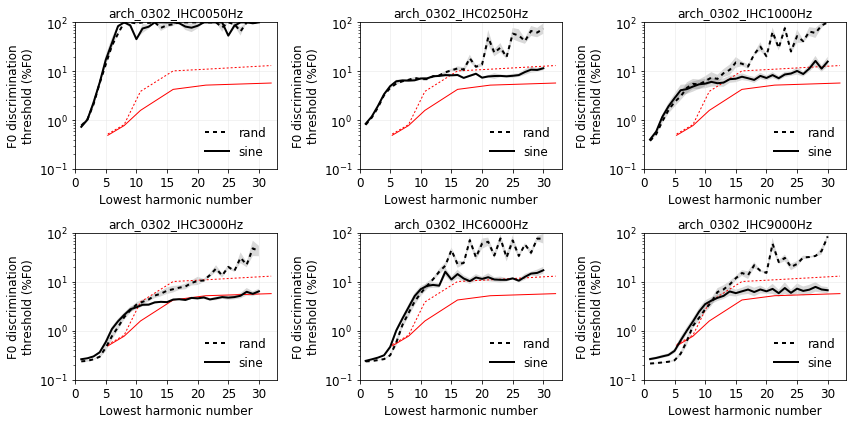

In [4]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_bernox2005(average_conditions=True)

NCOLS = min(len(model_keys), 3)
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_bernox_threshold_plot(ax, human_results_dict,
                                                           title_str=None, legend_on=False,
                                                           sine_plot_kwargs={'color':'r', 'lw':0.5*2},
                                                           rand_plot_kwargs={'color':'r', 'lw':0.5*2, 'dashes':(2, 2)})
    util_psychophysics_figures.make_bernox_threshold_plot(ax, results_dict_input,
                                                          kwargs_bootstrap={'metric_function':'mean'},
                                                          restrict_conditions=None,
                                                          title_str=title_str, legend_on=True,
                                                          include_yerr=True,
                                                          threshold_cap=100,
                                                          sine_plot_kwargs={'color':'k', 'lw':2},
                                                          rand_plot_kwargs={'color':'k', 'lw':2, 'dashes':(2, 2)})
    ax.grid(color=[0.9, 0.9, 0.9], linestyle='-', linewidth=0.5)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_12_05_PNDv08_archSearch01/2019NOV27_bernox2005plots_PND_v04_v07_v08_sr20000_arch0628mod.pdf', bbox_inches='tight')
# fig.savefig('figures/archive_2019_11_07_manipulating_bez2018model/2019NOV11_bernox2005plots_PND_v04_TLAS_halflowpassnoise_v02_RSB_bandwidth_manipulation.pdf', bbox_inches='tight')
# fig.savefig('figures/archive_2019_11_07_manipulating_bez2018model/2019NOV11_bernox2005plots_PND_v04_TLAS_RSB_bandwidth_manipulation.pdf', bbox_inches='tight')
# fig.savefig('figures/archive_2019_11_20_dataset_update_kids_speech/2019NOV20_bernox2005plots_PND_v04_TLAS_and_PND_v07_TLAS_sr20000_arch0628mod.pdf', bbox_inches='tight')



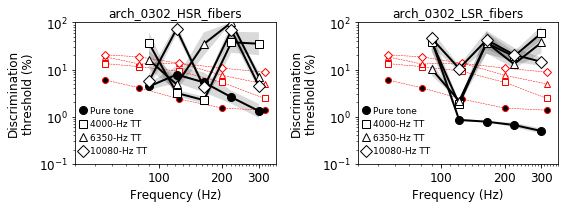

In [31]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_transposedtones()

NCOLS = min(len(model_keys), 5)
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_TT_threshold_plot(ax, human_results_dict,
                                                      title_str=None, legend_on=False,
                                                      plot_kwargs_update={'color': 'r', 'ls':'--', 'lw':0.5, 'ms':6})
    util_psychophysics_figures.make_TT_threshold_plot(ax, results_dict_input,
                                                      title_str=title_str,
                                                      legend_on=True,
                                                      include_yerr=True,
                                                      threshold_cap=100)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_10_05_archSearch00_parameterAnalysis/2019OCT03_arch0628_PND_v04_soundStatisticsManipulations_transposedtones.pdf', bbox_inches='tight')


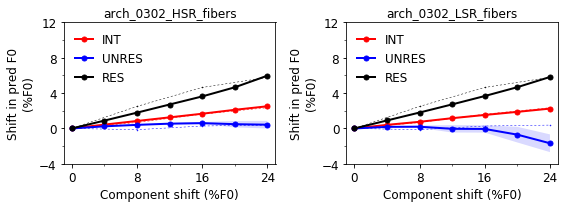

In [35]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_freqshiftedcomplexes(average_conditions=True)

NCOLS = min(len(model_keys), 5)
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_freqshiftedcomplexes_plot(ax, human_results_dict,
                                                              expt_key='spectral_envelope_centered_harmonic',
                                                              pitch_shift_key='f0_pred_shift_median',
                                                              condition_plot_kwargs={},
                                                              plot_kwargs_update={'ls':'--', 'lw': 0.5, 'ms':1, 'dashes':(4, 4)},
                                                              legend_on=False,
                                                              include_yerr=True)
    util_psychophysics_figures.make_freqshiftedcomplexes_plot(ax, results_dict_input,
                                                              expt_key='spectral_envelope_centered_harmonic',
                                                              pitch_shift_key='f0_pred_shift_median',
                                                              pitch_shift_err_key=None,
                                                              condition_plot_kwargs={},
                                                              plot_kwargs_update={},
                                                              title_str=title_str,
                                                              legend_on=True,
                                                              include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_10_05_archSearch00_parameterAnalysis/2019OCT03_arch0628_PND_v04_soundStatisticsManipulations_freqshifted.pdf', bbox_inches='tight')


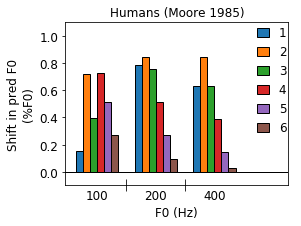

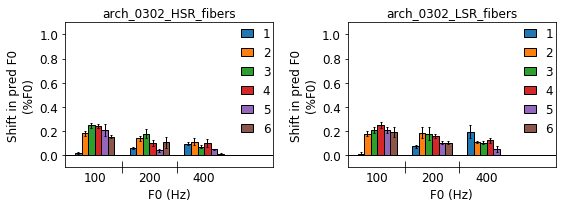

In [37]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_mistunedharmonics()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*1, 3*1))
util_psychophysics_figures.make_mistuned_harmonics_bar_graph(ax, human_results_dict,
                                                             pitch_shift_key='f0_pred_pct_median',
                                                             title_str='Humans (Moore 1985)',
                                                             legend_on=True)
plt.show()


NCOLS = min(len(model_keys), 5)
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_mistuned_harmonics_bar_graph(ax, results_dict_input,
                                                                 mistuned_pct=3.0,
                                                                 pitch_shift_key='f0_pred_pct_median',
                                                                 pitch_shift_err_key=None,
                                                                 title_str=title_str,
                                                                 legend_on=True,
                                                                 include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_10_05_archSearch00_parameterAnalysis/2019OCT03_arch0628_PND_v04_soundStatisticsManipulations_mistunedharmonics.pdf', bbox_inches='tight')


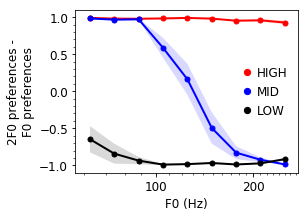

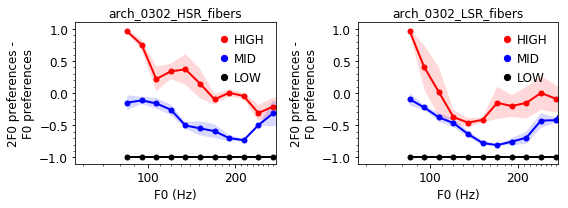

In [39]:
importlib.reload(util_psychophysics_figures)
human_results_dict = util_human_model_comparison.get_human_results_dict_altphasecomplexes(average_conditions=False)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*1, 3*1))
util_psychophysics_figures.make_altphase_plot(ax, human_results_dict,
                                              expt_key='filter_fl_bin_means',
                                              condition_plot_kwargs={},
                                              plot_kwargs_update={},
                                              title_str=None,
                                              legend_on=True,
                                              include_yerr=True)
plt.show()

NCOLS = min(len(model_keys), 5)
NROWS = int(np.ceil(len(model_keys) / NCOLS))
fig, ax_arr = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4*NCOLS, 3*NROWS))
# ax_arr = np.transpose(ax_arr)
ax_arr = ax_arr.flatten()

for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    util_psychophysics_figures.make_altphase_plot(ax, results_dict_input,
                                                  expt_key='filter_fl_bin_means',
                                                  expt_err_key=None,
                                                  condition_plot_kwargs={},
                                                  plot_kwargs_update={},
                                                  title_str=title_str,
                                                  legend_on=True,
                                                  include_yerr=True)

for idx in range(len(model_keys), len(ax_arr)): ax_arr[idx].axis('off')

plt.tight_layout()
plt.show()

# fig.savefig('figures/archive_2019_10_05_archSearch00_parameterAnalysis/2019OCT03_arch0628_PND_v04_soundStatisticsManipulations_altphase.pdf', bbox_inches='tight')


arch_0302_HSR_fibers


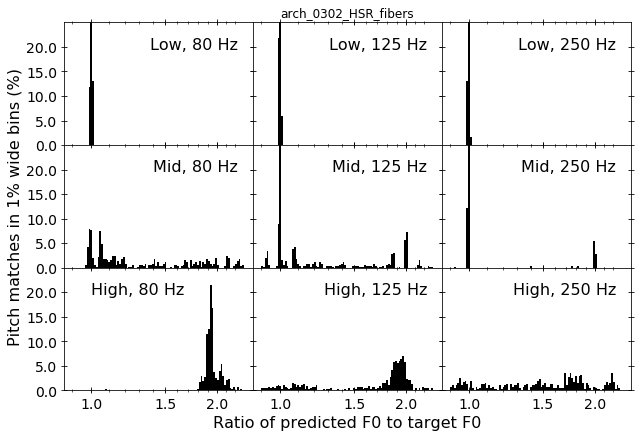

arch_0302_LSR_fibers


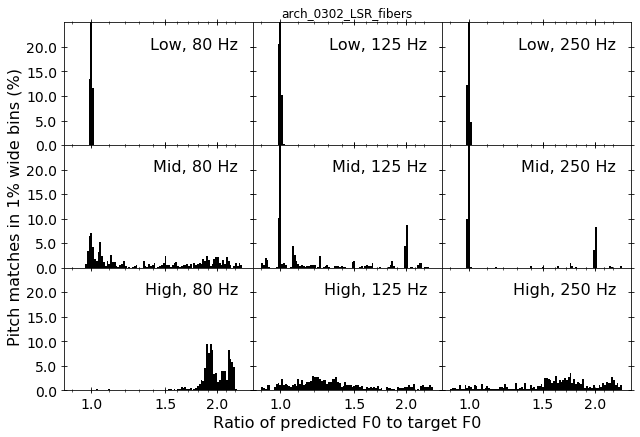

In [40]:
importlib.reload(util_psychophysics_figures)


for idx, model_key in enumerate(model_keys):
    results_dict_input = results_dicts[model_key]
    ax = ax_arr[idx]
    title_str=model_key
    
    print(title_str)
    fig, ax_arr = util_psychophysics_figures.make_altphase_histograms(
        results_dict_input,
        bin_step=0.01,
        figsize=(9,6),
        fontsize_labels=16,
        fontsize_legend=16,
        fontsize_ticks=14,
        xticks=[1.0, 1.5, 2.0],
        xlimits=[0.9, 2.3])
    ax_arr[1].set_title(title_str)
    plt.show()



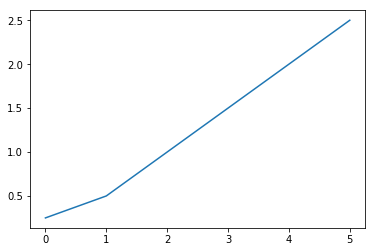

In [8]:
plt.figure()
plt.plot([0.25, 0.5, 1, 1.5, 2, 2.5])
plt.show()